<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/%D0%9F%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%8B_%D0%B4%D0%BB%D1%8F_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3%D0%B0_%22TabNet_SDSS%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подгружаем необходимые библиотеки 

In [2]:
pip install pytorch-tabnet

In [3]:
import numpy as np
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

from pytorch_tabnet.tab_model import TabNetClassifier

Подгружаем данные из SDSS обзора, которые были получены: http://skyserver.sdss.org/CasJobs/mydbcontent.aspx?ObjName=SpecPhotoAll&ObjType=TABLE&context=DR16&type=normal 

Здесь уже выполнены следующие преобразования:

1) Удалены строчки с разряженными данными (где отсутствуют интересующие нас фотометрические признаки), выбросы, удалены не интересующие нас признаки

2) Удалены дубрирующиеся данные

3) Объединены основные спектральные классы звезд 

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Научная работа/Nauch/Результат/data/df_done_sub.csv') #выборка с уже объединеными подклассами звезд 
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,GALAXY,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,QSO,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,GALAXY,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,GALAXY,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,GALAXY,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [7]:
df.shape

(4614588, 17)

In [8]:
df.describe()

,objID,ra,dec,z,zErr,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
count,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06
mean,1.237665e+18,1.728012e+02,2.406577e+01,5.773699e-01,5.854844e-02,2.240051e+01,2.122111e+01,2.029666e+01,1.974275e+01,1.938488e+01,2.136179e+01,2.051423e+01,1.961589e+01,1.905677e+01,1.868825e+01
std,8.417649e+12,9.444408e+01,1.910161e+01,7.297733e-01,1.930832e+01,1.954846e+00,1.940199e+00,1.713228e+00,1.552831e+00,1.512268e+00,2.117606e+00,1.993697e+00,1.852755e+00,1.742048e+00,1.677772e+00
min,1.237646e+18,9.090791e-05,-1.970271e+01,-1.144691e-02,-6.000000e+00,6.752299e+00,7.464891e+00,8.449972e+00,7.611034e+00,6.444011e+00,1.020505e+01,1.043573e+01,1.033073e+01,1.027642e+01,8.829096e+00
25%,1.237659e+18,1.271012e+02,6.893257e+00,6.228666e-02,2.494150e-05,2.105644e+01,1.980771e+01,1.908989e+01,1.871800e+01,1.840915e+01,1.987525e+01,1.888042e+01,1.805814e+01,1.767278e+01,1.742591e+01
50%,1.237664e+18,1.741648e+02,2.352539e+01,4.268281e-01,9.249016e-05,2.259238e+01,2.147956e+01,2.063976e+01,2.007801e+01,1.967025e+01,2.116473e+01,2.097991e+01,2.011406e+01,1.942030e+01,1.898551e+01
75%,1.237668e+18,2.271129e+02,3.864779e+01,7.037950e-01,1.989703e-04,2.390630e+01,2.277750e+01,2.155568e+01,2.080758e+01,2.034762e+01,2.250614e+01,2.198993e+01,2.102539e+01,2.035791e+01,1.984414e+01
max,1.237681e+18,3.599999e+02,8.485214e+01,7.051930e+00,3.068822e+04,3.192045e+01,3.032868e+01,2.971638e+01,2.995165e+01,2.748061e+01,3.428534e+01,3.330923e+01,3.088891e+01,3.268382e+01,3.119199e+01


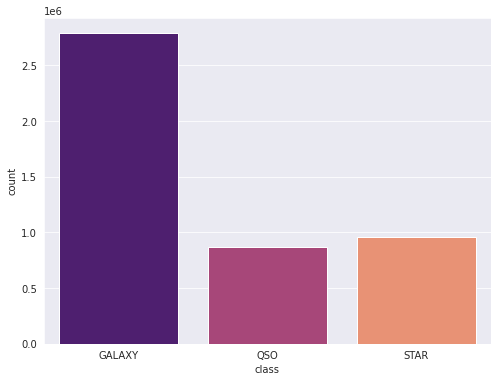

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.countplot(x=df['class'], palette = 'magma')

# Подготовка данных для классификатора

In [10]:
target = 'class'

add_columns = ['subClass', 'objID', 'z', 'zErr', 'ra', 'dec']

photo_columns = ['psfMag_u',	'psfMag_g',	'psfMag_r',	'psfMag_i',	'psfMag_z',
                 'cModelMag_u',	'cModelMag_g',	'cModelMag_r',	'cModelMag_i',	'cModelMag_z']

feature_columns = (
    photo_columns + add_columns + [target])

In [11]:
labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
df.replace({target:labels}, inplace = True)

In [12]:
X =  df.drop(add_columns + [target], axis = 1).values
y = df[target].values
X.shape

(4614588, 10)

In [13]:
def data_preparation(X, y, test_size = 0.8):

    X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[y==2], y[y==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[y==3], y[y==3], test_size=test_size, random_state = 43)
    
    count = 5000
    count1 = 5000

    X_train, X_test = np.concatenate((X1_train[:count], X2_train[:count], X3_train[:count])), np.concatenate((X1_test[:count1], X2_test[:count1], X3_test[:count1]))
    y_train, y_test = np.concatenate((y1_train[:count], y2_train[:count], y3_train[:count])), np.concatenate((y1_test[:count1], y2_test[:count1], y3_test[:count1]))
    

    return [X_train, X_test, y_train, y_test, X1_train, X1_test, y1_train, y1_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test]

# Аугментация данных 

Полиномиальная 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, include_bias=False)
X = poly.fit_transform(X)

In [ ]:
X, y

(array([[ 23.38412   ,  23.00183   ,  22.67571   , ..., 443.40651413,
         427.4183987 , 412.0067742 ],
        [ 22.52914   ,  23.78679   ,  23.21358   , ..., 447.2924675 ,
         437.01919989, 426.98188533],
        [ 25.44541   ,  23.13342   ,  23.57675   , ..., 585.52336181,
         499.01649361, 425.2903934 ],
        ...,
        [ 23.02686   ,  23.20499   ,  23.40832   , ..., 481.5694192 ,
         462.66209374, 444.49710561],
        [ 22.33769   ,  22.44495   ,  22.31467   , ..., 450.38771508,
         435.51127918, 421.12621625],
        [ 22.66886   ,  22.29422   ,  21.80799   , ..., 435.46966777,
         435.24951132, 435.02946617]]), array([2, 3, 2, ..., 3, 2, 2]))

Линейная комбинация

In [14]:
stop = 10 #X.shape[1]
for i in range(stop):
  for j in range(i+1, stop):
    X = np.concatenate((X, np.array([X[:, i] + X[:, j]]).T, np.array([X[:, i] - X[:, j]]).T), axis=1)

In [15]:
X.shape, y

((4614588, 100), array([2, 3, 2, ..., 3, 2, 2]))

# Классификатор Звезд, Галактик и Квазаров

In [16]:
data_split = data_preparation(X, y)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 5000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = np.concatenate((X1_test[2*count : 3*count], X2_test[2*count : 3*count], X3_test[2*count : 3*count]))
y_valid      = np.concatenate((y1_test[2*count : 3*count], y2_test[2*count : 3*count], y3_test[2*count : 3*count]))

In [17]:
X_train.shape, X_test.shape

((15000, 100), (15000, 100))

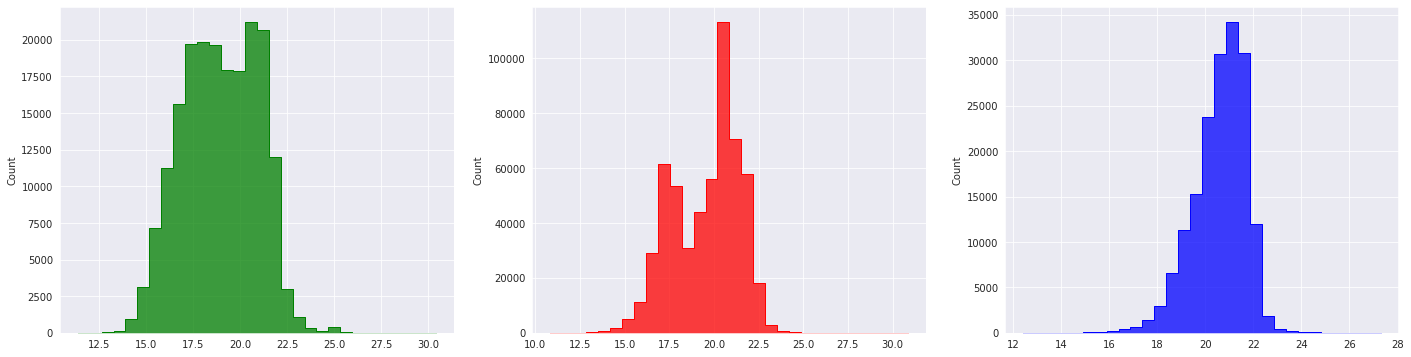

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X1_train[:, 7], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(X2_train[:, 7], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(X3_train[:, 7], ax = ax3, bins = 30, color = 'b', element="step")

# Подбор параметров

# Random Forest and Gradient boosting

Нормализация данных


In [19]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

In [20]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score

def scor(y_test, y_pred):
  return accuracy_score(y_test, y_pred)

lgb_reg_params = {
    'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'min_child_samples':hp.randint('min_child_samples', 50)+1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'num_leaves' :      hp.randint('num_leaves', 100)+10,
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.99),
    'n_estimators':     hp.randint('n_estimators', 1500)+100
}
lgb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['score'] = lambda y, pred: -accuracy_score(y, pred)


rf_reg_params = {
    #'max_depth':        hp.choice('max_depth',        np.arange(1, 16, 1, dtype=int)), используем потом
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 3, 5, 7, 10, 14]),
    'min_samples_split':hp.choice('min_samples_split', np.arange(0.01, 1, 0.2)),
    'max_features':     hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'n_estimators':     hp.choice('n_estimators', np.array([150, 300, 500, 700, 900]))
}
rf_fit_params = {
}
rf_para = dict()
rf_para['reg_params'] = rf_reg_params
rf_para['fit_params'] = rf_fit_params
rf_para['score'] = lambda y, pred: -scor(y, pred)

In [21]:
import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def rf_reg(self, para):
        reg = RandomForestClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        if len(para['fit_params'])>0:
            reg.fit(self.x_train, self.y_train,
                  eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                  **para['fit_params'])
        else:
            reg.fit(self.x_train, self.y_train)
        pred = reg.predict(self.x_test)
        loss = para['score'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [26]:
obj = HPOpt(X_train_norm, X_test_norm, y_train, y_test)

In [27]:
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=1000)

100%|██████████| 1000/1000 [2:44:53<00:00,  9.89s/it, best loss: -0.8928]


In [28]:
lgb_opt

({'colsample_bytree': 0.6437405148446416,
  'learning_rate': 0.0741521019613115,
  'min_child_samples': 9,
  'min_child_weight': 0.43858057836890685,
  'n_estimators': 77,
  'num_leaves': 59},
 <hyperopt.base.Trials at 0x7f7912522c10>)

In [276]:
lgb_opt

({'colsample_bytree': 0.40108236142610054,
  'learning_rate': 0.010201405269265667,
  'min_child_samples': 2,
  'min_child_weight': 0.002749225168519276,
  'n_estimators': 747,
  'num_leaves': 78},
 <hyperopt.base.Trials at 0x7f72ed5cec90>)

In [45]:
gb = lgb.LGBMClassifier(
  **{'colsample_bytree': 0.6437405148446416,
  'learning_rate': 0.0741521019613115,
  'min_child_samples': 9+1,
  'min_child_weight': 0.43858057836890685,
  'n_estimators': 77+100,
  'num_leaves': 59+10}
  )
gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.6437405148446416, importance_type='split',
               learning_rate=0.0741521019613115, max_depth=-1,
               min_child_samples=10, min_child_weight=0.43858057836890685,
               min_split_gain=0.0, n_estimators=177, n_jobs=-1, num_leaves=69,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [38]:
gb = lgb.LGBMClassifier(
  **{'colsample_bytree': 0.40108236142610054,
  'learning_rate': 0.010201405269265667,
  'min_child_samples': 2+1,
  'min_child_weight': 0.002749225168519276,
  'n_estimators': 747+100,
  'num_leaves': 78+10}
  )
gb.fit(X_train_norm, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.40108236142610054, importance_type='split',
               learning_rate=0.010201405269265667, max_depth=-1,
               min_child_samples=3, min_child_weight=0.002749225168519276,
               min_split_gain=0.0, n_estimators=847, n_jobs=-1, num_leaves=88,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [46]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.90      0.87      0.88      5000
           2       0.91      0.95      0.93      5000
           3       0.87      0.85      0.86      5000

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Confusion Matrix: 
 [[4353  139  508]
 [  82 4766  152]
 [ 408  319 4273]]
Training Score:  0.9833333333333333
Testing Score:  0.8928


In [ ]:
rf_opt

({'max_features': 1,
  'min_samples_leaf': 3,
  'min_samples_split': 0,
  'n_estimators': 3},
 <hyperopt.base.Trials at 0x7f5dd6765da0>)

In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train_norm, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
pred = rf.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
rf_train_acc = accuracy_score(y_train, rf.predict(X_train_norm))
print('Training Score: ', rf_train_acc)
rf_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', rf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.85      0.87      5000
           2       0.91      0.94      0.93      5000
           3       0.84      0.84      0.84      5000

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

Confusion Matrix: 
 [[4265  147  588]
 [  90 4722  188]
 [ 483  325 4192]]
Training Score:  1.0
Testing Score:  0.8786


# TabNet


In [ ]:
import torch

In [ ]:
from pytorch_tabnet.pretraining import TabNetPretrainer

unsupervised_model = TabNetPretrainer(
    n_d=64, n_a=64, n_steps=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train_pred,
    eval_set=[X_val_pred],
    max_epochs=10 , patience=5,
    batch_size=2048, virtual_batch_size=128,
    pretraining_ratio=0.8,
)

Device used : cuda
epoch 0  | loss: 5594142.36936| val_0_unsup_loss: 72.8139 |  0:00:47s
epoch 1  | loss: 76.50219| val_0_unsup_loss: 72.81198|  0:01:34s
epoch 2  | loss: 77.00028| val_0_unsup_loss: 72.81197|  0:02:22s
epoch 3  | loss: 78.08024| val_0_unsup_loss: 72.81196|  0:03:10s
epoch 4  | loss: 76.95357| val_0_unsup_loss: 72.81197|  0:03:58s
epoch 5  | loss: 76.87502| val_0_unsup_loss: 72.81197|  0:04:46s
epoch 6  | loss: 76.28248| val_0_unsup_loss: 72.81196|  0:05:33s
epoch 7  | loss: 76.28192| val_0_unsup_loss: 72.81197|  0:06:21s
epoch 8  | loss: 81.99902| val_0_unsup_loss: 72.81196|  0:07:09s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_unsup_loss = 72.81196
Best weights from best epoch are automatically used!


In [ ]:
clf = TabNetClassifier(n_d=64, n_a=64, n_steps=5,
                       gamma=1.5, n_independent=2, n_shared=2,
                       lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
)

Device used : cuda


In [ ]:
max_epochs = 100 #if not os.getenv("CI", False) else 2

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs , patience=20,
    batch_size=512, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=unsupervised_model
) 

NameError: ignored

In [ ]:
pred = clf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
clf_train_acc = accuracy_score(y_train, clf.predict(X_train))
print('Training Score: ', clf_train_acc)
clf_test_acc = accuracy_score(y_test, pred)
print('Training Score: ', clf_test_acc)

In [ ]:
# plot losses
plt.plot(clf.history['loss'])

In [ ]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [ ]:
clf.feature_importances_, gb.feature_importances_#, rf.feature_importances_

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")